In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.datasets import make_classification
from collections import Counter 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import (roc_curve, precision_recall_curve, auc, make_scorer, classification_report, 
                             recall_score, accuracy_score, precision_score, confusion_matrix)
from sklearn.model_selection import RandomizedSearchCV,train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from mlxtend.plotting import plot_decision_regions

In [55]:
X,y =make_classification(n_samples=5000, n_features=6, n_informative=2, n_classes=2, n_clusters_per_class=1,
                        n_redundant=0,n_repeated=0,weights=[0.01,0.99],class_sep=0.8,random_state=0)
print("Dados em cada uma das classes",sorted(Counter(y).items()))

Dados em cada uma das classes [(0, 68), (1, 4932)]


In [56]:
x_train,x_test=train_test_split(X)
print(x_train.shape,x_test.shape)
y_train,y_test=train_test_split(y)
print(y_train.shape,y_test.shape)

(3750, 6) (1250, 6)
(3750,) (1250,)


Muitas vezes temos um algoritmo para solucionar um problema de classificação ou regressão mas o mesmo possui diversos parâmetros que, se combinados de diferentes formas, podem produzir resultados distintos. Nesse caso, para testar esses diferentes parâmetros temos algumas alternativas. A priemeira seria, manualmente, tentar diferentes valores para esses parâmetros, pegar os resultados finais e definir qual seria o melhor modelo. Essa solução parece ser pouco eficiente na medida que exige muito esforço e um enorme risco de calibração, em especial para parâmetros contínuos. A segunda solução seria fazer esse ajuste fino usando o GridSearchCV. Nesse caso, testamos diferentes valores para os hiperparâmetros e obtemos o classificador que apresenta o maior score para recall. Por fim, podemos ajustar nosso hiperparâmetro considerando como métrica a curva precision-recall ou roc.

### GridSearchCV

Vamos ver como aplicar o GridSearchCV a um simples problema para o estimador svm. Veja abaixo que esse estimador possui diversos parâmetros, em especial queremos encontrar qual seria o melhor parâmetro para C, degree e a função kernel. Veja que definimos o estimador e depois o intervalo de oscilação dos parâmetros. A seguir, definimos o GridSearchCV.

In [37]:
SVC()

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [65]:
import warnings
warnings.filterwarnings("ignore")
clf1 = SVC(probability=True)   #classificador
params1 = {'C': [1, 10, 100],"degree":[1,2,3],"kernel":('linear',"rbf")}   #parametros
gs1=GridSearchCV(clf1,params1,cv=5,n_jobs=-1,error_score=0)
gs1.fit(x_train,y_train)
y_pred=gs1.predict(x_test)
y_prob=gs1.predict_proba(x_test)
print(gs1.best_estimator_)
print(gs1.best_score_)
print(gs1.best_params_)
print(gs1.cv_results_['params'][gs1.best_index_])

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
0.988
{'C': 1, 'degree': 1, 'kernel': 'linear'}
{'C': 1, 'degree': 1, 'kernel': 'linear'}


=================================

Agora podemos testar outro estimador, o RandomForestClassifier, que possui um conjunto diferente de hiperparâmetros. Primeiro vemos como é o estimador. Vamos testar diferentes combinações com "min_samples_split", "n_estimators", "max_depth" e " max_features". Mas, além disso, vamos ver como seria com diferentes métricas para o score.

In [47]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [58]:
clf2 = RandomForestClassifier()
params2 = {'min_samples_split':range(2, 32, 10),'n_estimators':[100, 300],
           'max_depth':[3, 5, 15, 25],'max_features':[2,4,6]}
scor={"AUC":'roc_auc',"Accuracy":make_scorer(accuracy_score)}
gs2=GridSearchCV(clf2,param_grid=params2,scoring=scor,cv=5,refit="AUC",
                 return_train_score=True,n_jobs=-1,error_score=0)
gs2.fit(x_train,y_train)
print(gs2.best_estimator_)
print(gs2.best_score_)
print(gs2.best_params_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=12,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.5710301394511921
{'max_depth': 15, 'max_features': 2, 'min_samples_split': 12, 'n_estimators': 300}


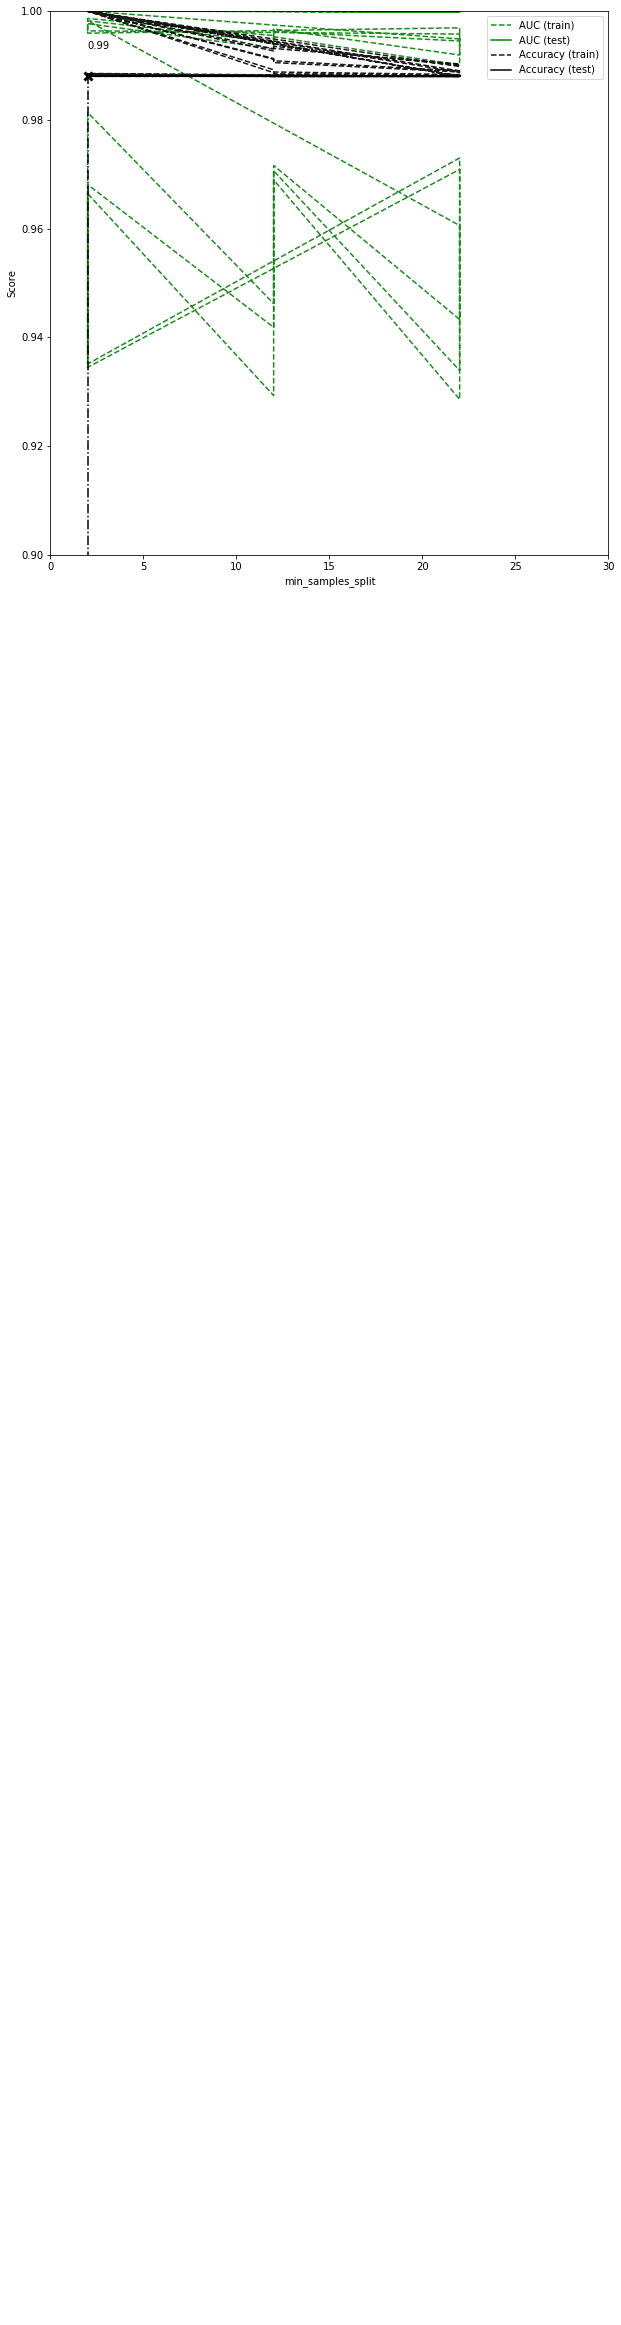

In [64]:
resultados=gs2.cv_results_
plt.figure(figsize=(10,10))

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 30)
ax.set_ylim(0.90, 1)
X_axis = np.array(resultados['param_min_samples_split'].data, dtype=float)
for scorer, color in zip(sorted(scor), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = resultados['mean_%s_%s' % (sample, scorer)]
        sample_score_std = resultados['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.9,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(resultados['rank_test_%s' % scorer] == 1)[0][0]
    best_score = resultados['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

===========================

Agora vamos ver como podemos otimizar um estimador (classifier) usando o recurso do cross-validation. Para tanto vamos especificar o estimador SVC para diferentes hiperparâmetros e scores.

In [75]:
clf3 = SVC(probability=True)   #classificador
params1 = {'C': [1, 10, 100],"degree":[1,2,3],"kernel":('linear',"rbf")}   #parametros
scores=["precision","recall"]
for j in scores:
    classif=GridSearchCV(clf3,params1,cv=5,scoring=j)
    classif.fit(x_train,y_train)
    print(classif.best_params_)
    y_pred3=classif.predict(x_test)
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))

{'C': 1, 'degree': 1, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.98      1.00      0.99      1227

   micro avg       0.98      0.98      0.98      1250
   macro avg       0.49      0.50      0.50      1250
weighted avg       0.96      0.98      0.97      1250

[[   0   23]
 [   0 1227]]
{'C': 1, 'degree': 1, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.98      1.00      0.99      1227

   micro avg       0.98      0.98      0.98      1250
   macro avg       0.49      0.50      0.50      1250
weighted avg       0.96      0.98      0.97      1250

[[   0   23]
 [   0 1227]]


### Random Search
Esse método implementa uma busca aleatória dos parâmetros ótimos a partir de uma seleção de possíveis valores em uma distibuição.

In [12]:
random = RandomizedSearchCV(estimator=clf, param_distributions=params, cv = 5, n_jobs=-1)
RS=random.fit(X,y)
print(RS.best_params_,RS.best_score_)

{'shuffle': True, 'n_iter': 69, 'alpha': 0.1} 0.9348


### PIPELINE

O recurso "pipeline" é uma classe que possui uma ferramenta bem útil para agregar diferentes "transformadores" em um estimador dentro de um objeto e que possui dois importantes componentes: <br>
1. Transformers: 
  Implementa tanto o fit() quanto o transform().
2. Estimators:
  Implementa o fit() e o predict()

#### Um pipeline simples

In [2]:
from sklearn.metrics import f1_score,classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from mlxtend.plotting import plot_decision_regions

In [4]:
import warnings
warnings.filterwarnings("ignore")
pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', LogisticRegression())])
p1=pipeline.fit(X,y)
y_pred=p1.predict(X)
print(classification_report(y, y_pred))
print(confusion_matrix(y,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.14      0.25        64
           1       0.81      0.72      0.76       262
           2       0.98      1.00      0.99      4674

   micro avg       0.97      0.97      0.97      5000
   macro avg       0.93      0.62      0.67      5000
weighted avg       0.97      0.97      0.97      5000

[[   9   43   12]
 [   0  189   73]
 [   0    2 4672]]


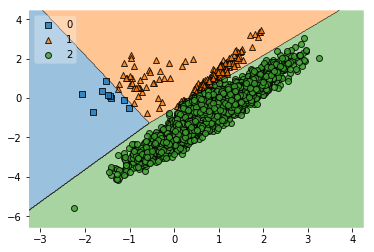

In [5]:
plot_decision_regions(X=X,y=y_pred,clf=p1,legend=2)

#### pipeline com Keras

In [3]:
from keras.layers import Dense, Dropout
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


Primeiro vamos construir o modelo que irá ser utilizado na estimativa

In [4]:
def create_model(optimizer='adagrad',kernel_initializer='glorot_uniform', dropout=0.2):
    model = Sequential()
    model.add(Dense(64,activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='sigmoid',kernel_initializer=kernel_initializer))
    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    return model

Quando vamos usar o pipeline, lembre-se que temos duas componentes, o transformer, que no nosso caso seria mudar a escala dos dados "StandardScaler()", e o estimador, que para esse exemplo seria o "KerasClassifier"

In [5]:
scaler = StandardScaler()    #transform
keras1 = KerasClassifier(build_fn=create_model,verbose=0)   #fit e predict (nosso estimador)

In [6]:
param_grid = {
    'clf__optimizer':['adam','adagrad'],
    'clf__epochs':[10,30],
    'clf__dropout':[0.1,0.2],
    'clf__kernel_initializer':['normal','uniform']
}

In [7]:
pipeline = Pipeline([
    ('preprocess',scaler),
    ('clf',keras1)
])

In [ ]:
grid = GridSearchCV(pipeline, cv=3, param_grid=param_grid,n_jobs=-1)
p2=grid.fit(X, y)

In [ ]:
# summarize results
print("Best: %f using %s" % (p2.best_score_, p2.best_params_))
means = p2.cv_results_['mean_test_score']
stds = p2.cv_results_['std_test_score']
params = p2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
y_pred=p2.predict(X)
plot_decision_regions(X=X,y=y,clf=svm1,legend=2)
print(confusion_matrix(y,y_pred))